In [12]:
pip install xgboost>=1.6  

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "numpy<2.0"

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 1.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 KB 708.1 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyarrow==14.0.1

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 2.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time
from pyspark.sql.functions import col
from sklearn.metrics import classification_report

# 1. Khởi tạo Spark
spark = SparkSession.builder.appName("Spark_RF_MLlib").getOrCreate()

# 4. Đọc và chuẩn bị dữ liệu train
train_df = spark.read.csv("train.csv", header=True, inferSchema=True)
vec_cols = [c for c in train_df.columns if c != 'label']
assembler = VectorAssembler(inputCols=vec_cols, outputCol="features")
train_df_vec = assembler.transform(train_df).select("features", col("label").cast("double"))

# Đọc và chuẩn bị dữ liệu test
test_df = spark.read.csv("test.csv", header=True, inferSchema=True)
assembler_test = VectorAssembler(inputCols=[c for c in test_df.columns if c != 'label'], outputCol="features")
test_df_vec = assembler_test.transform(test_df).select("features", col("label").cast("double"))

# 5. Huấn luyện Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=200,
    maxDepth=30,
    minInstancesPerNode=1,
    featureSubsetStrategy='sqrt',
    seed=42,
    subsamplingRate=1.0)

start_time = time.time()
rf_model = rf.fit(train_df_vec)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# 6. Dự đoán
predictions = rf_model.transform(test_df_vec)

# 7. Đánh giá
evaluator_acc = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
evaluator_precision = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')

rf_accuracy = evaluator_acc.evaluate(predictions)
rf_f1 = evaluator_f1.evaluate(predictions)
rf_precision = evaluator_precision.evaluate(predictions)
rf_recall = evaluator_recall.evaluate(predictions)

print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")

# 8. Classification Report (giống sklearn)
y_true = predictions.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


25/05/31 12:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1670.9 KiB
25/05/31 12:37:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/05/31 12:37:17 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
25/05/31 12:37:18 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/31 12:37:18 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 12:37:19 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
25/05/31 12:37:19 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 12:37:20 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 12:37:20 WARN DAGScheduler: Broadcasting large task binary with size 2006.9 KiB


Training time: 6.55 seconds


25/05/31 12:37:21 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 12:37:21 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 12:37:21 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 12:37:21 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


Accuracy: 0.9650
Precision: 0.9658
Recall: 0.9650
F1 Score: 0.9646

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9481    1.0000    0.9733        73
         1.0     0.9677    0.9836    0.9756        61
         2.0     0.9836    0.9091    0.9449        66

    accuracy                         0.9650       200
   macro avg     0.9665    0.9642    0.9646       200
weighted avg     0.9658    0.9650    0.9646       200



25/05/31 12:37:22 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


In [17]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time
from sklearn.metrics import classification_report

# 1. Khởi tạo SparkSession
spark = SparkSession.builder.appName("XGBoost_Spark_DF").getOrCreate()

# 2. Đọc và chuẩn bị dữ liệu train
train_df = spark.read.csv("train.csv", header=True, inferSchema=True)
feature_cols = [c for c in train_df.columns if c != 'label']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_df_vec = assembler.transform(train_df).select("features", col("label").cast("float"))

# 3. Đọc và chuẩn bị dữ liệu test
test_df = spark.read.csv("test.csv", header=True, inferSchema=True)
assembler_test = VectorAssembler(inputCols=[c for c in test_df.columns if c != 'label'], outputCol="features")
test_df_vec = assembler_test.transform(test_df).select("features", col("label").cast("float"))

# 4. Khởi tạo mô hình XGBoost
xgb = SparkXGBClassifier(
    num_class=3,        # sửa nếu số lớp khác
    eval_metric='mlogloss',
    seed=42
)

# 5. Huấn luyện model và đo thời gian
start_time = time.time()
xgb_model = xgb.fit(train_df_vec)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# 6. Dự đoán trên tập test
predictions = xgb_model.transform(test_df_vec)

# 7. Đánh giá bằng Spark
evaluator_acc = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
evaluator_precision = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
evaluator_recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')

acc = evaluator_acc.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 8. Classification Report như sklearn
y_true = predictions.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# 9. Đóng Spark nếu không dùng tiếp
spark.stop()


2025-05-31 12:24:02,477 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-05-31 12:24:05,194 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[12:24:06] Task 0 got rank 0
[12:24:06] [0]	training-mlogloss:0.81174
[12:24:06] [1]	training-mlogloss:0.62488
[12:24:06] [2]	training-mlogloss:0.50314
[12:24:06] [3]	training-mlogloss:0.40390
[12:24:06] [4]	training-mlogloss:0.32909
[12:24:06] [5]	training-mlogloss:0.27276
[12:24:06] [6]	training-mlogloss:0.22826
[12:24:06] [7]	training-mlogloss:0.19359
[12:24:06] [8]	training-mlogloss:0.16483
[12:24:06] [9]	training-mlogloss:0.14259
[12:24:06] [10]	training-mlogloss:0.12418
[12:24:06] [11]	training-mlogloss:0.10967
[12:24:06] [12]	training-mlogloss:0.09722
[12:24

Training time: 5.57 seconds


2025-05-31 12:24:08,084 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-31 12:24:08,304 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-31 12:24:08,516 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-31 12:24:08,727 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 0.9600
Precision: 0.9603
Recall: 0.9600
F1 Score: 0.9597


2025-05-31 12:24:09,119 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



Classification Report:
              precision    recall  f1-score   support

         0.0     0.9474    0.9863    0.9664        73
         1.0     0.9677    0.9836    0.9756        61
         2.0     0.9677    0.9091    0.9375        66

    accuracy                         0.9600       200
   macro avg     0.9610    0.9597    0.9599       200
weighted avg     0.9603    0.9600    0.9597       200



In [22]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.6 MB/s eta 0:00:0000:0100:01
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
  Using cached pillow-11.2.1-cp310-cp310-manylinux_2_28_x86_64.whl (4.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)


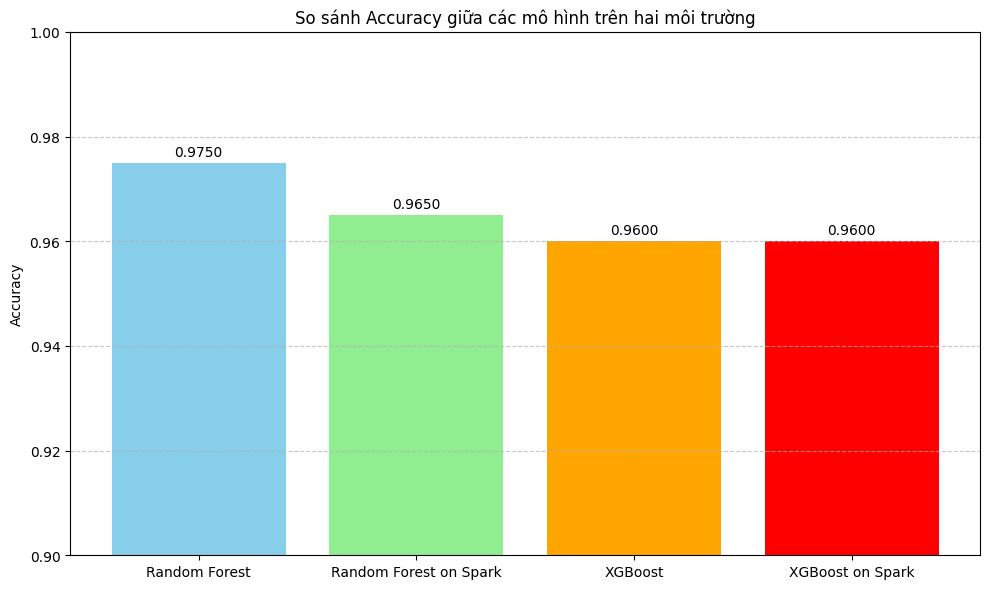

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Models and their accuracies
models = [
    {"name": "Random Forest", "accuracy": 0.9750},
    {"name": "Random Forest on Spark", "accuracy": 0.9650},
    {"name": "XGBoost", "accuracy": 0.9600},
    {"name": "XGBoost on Spark", "accuracy": 0.9600},
]

# Extract names and scores
model_names = [model["name"] for model in models]
accuracies = [model["accuracy"] for model in models]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'orange', 'red'])

# Formatting
ax.set_ylabel('Accuracy')
ax.set_title('So sánh Accuracy giữa các mô hình trên hai môi trường')
ax.set_ylim([0.9, 1.0])
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
